In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor
import gymnasium as gym

In [3]:
from uav_active_sensing.config import MODELS_DIR, DEVICE, IMG_BATCH_SIZE
from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_exploration_env import RewardFunction
from uav_active_sensing.modeling.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.plots import visualize_reconstruction
from uav_active_sensing.modeling.ppo import Agent, PPOConfig, make_env
from uav_active_sensing.plots import visualize_tensor, visualize_reconstruction


2025-03-13 15:28:36.866 | INFO     | uav_active_sensing.config:<module>:14 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing
2025-03-13 15:28:36.867 | INFO     | uav_active_sensing.config:<module>:36 - Using device: cpu


ModuleNotFoundError: No module named 'uav_active_sensing.modeling.img_exploration_env'

In [36]:


def load_model_state_dict(weights_path: str, device: str):

    weights_path = Path(weights_path)

    if not weights_path.exists():
        raise FileNotFoundError(f"Model file not found at {weights_path}")

    state_dict = torch.load(weights_path, map_location=torch.device(device), weights_only=True)

    print(f"State dict loaded from {weights_path} onto {device}")

    return state_dict

In [17]:
trained_model_state_dict = load_model_state_dict(MODELS_DIR / "runs/ImageExploration-v0__ppo__42__1739429656/ppo.cleanrl_model", DEVICE)

State dict loaded from /home/tcouso/uav_active_sensing/models/runs/ImageExploration-v0__ppo__42__1739429656/ppo.cleanrl_model onto cpu


In [18]:
image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)


tiny_imagenet_val_dataset = TinyImageNetDataset(split="val", transform=image_processor)
tiny_imagenet_val_loader = DataLoader(
    tiny_imagenet_val_dataset, batch_size=IMG_BATCH_SIZE, collate_fn=tiny_imagenet_collate_fn
)

mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
reward_function = RewardFunction(mae_model)
ppo_config = PPOConfig()

In [46]:
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [19]:
image_processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [20]:
def reverse_image_processing(tensor, image_processor):
    """
    Reverses the transformations applied by AutoImageProcessor.
    
    Args:
        tensor (torch.Tensor): Preprocessed image tensor (C, H, W).
        image_processor (AutoImageProcessor): The processor used for transformation.

    Returns:
        PIL.Image: The reversed image.
    """
    tensor = tensor.clone().detach().cpu()

    # Step 1: Unnormalize
    if image_processor.do_normalize:
        mean = torch.tensor(image_processor.image_mean).view(3, 1, 1)
        std = torch.tensor(image_processor.image_std).view(3, 1, 1)
        tensor = tensor * std + mean  # Reverse normalization

    # Step 2: Rescale from [0,1] back to [0,255]
    if image_processor.do_rescale:
        tensor = tensor * (1 / image_processor.rescale_factor)

    # Step 3: Convert to uint8 format
    tensor = tensor.clamp(0, 255).byte()
    
    # Step 4: Convert from CHW (C, H, W) to HWC (H, W, C) for PIL compatibility
    tensor = tensor.permute(1, 2, 0).numpy()
    
    # Step 5: Convert to PIL Image
    return Image.fromarray(tensor)

### RL inference and MAE training (second half of an epoch)

In [32]:
def unwrap_env(env):
    """ Recursively unwraps a vectorized environment to get the base env. """
    while hasattr(env, "env"):
        env = env.env
    return env

In [36]:
for img_batch in tiny_imagenet_val_loader: 
    vect_env = gym.vector.SyncVectorEnv(
        [make_env(img.unsqueeze(0), reward_function, ppo_config.gamma) for img in img_batch]
    )
    trained_agent = Agent(vect_env)
    trained_agent.load_state_dict(trained_model_state_dict)
    trained_agent.eval()

    global_step = 0
    next_obs, _ = vect_env.reset(seed=ppo_config.seed)
    next_obs = torch.Tensor(next_obs).to(DEVICE)
    next_done = torch.zeros(ppo_config.num_envs).to(DEVICE)

    # Image sampling
    for step in range(0, ppo_config.num_steps):
        global_step += ppo_config.num_envs

        with torch.no_grad():
            action, logprob, _, value = trained_agent.get_action_and_value(next_obs)
            action = torch.round(action).int()

        next_obs, reward, terminations, truncations, infos = vect_env.step(action.cpu().numpy())
        next_done = np.logical_or(terminations, truncations)
        next_obs, next_done = torch.Tensor(next_obs).to(DEVICE), torch.Tensor(next_done).to(
            DEVICE
        )
    base_envs = [unwrap_env(e) for e in vect_env.envs]
    img_pairs = [(env.img, env.sampled_img) for env in base_envs]
    # TODO: Store this somewhere for visualizing sampling progress across epochs

    break

# TODO: Reconstruct full images with MAE from pairs of batches of sampled and complete images. Optionally fine tune MAE

/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/gymnasium/wrappers/common.py:515: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  self.episode_returns += reward


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8276899..0.85046077].


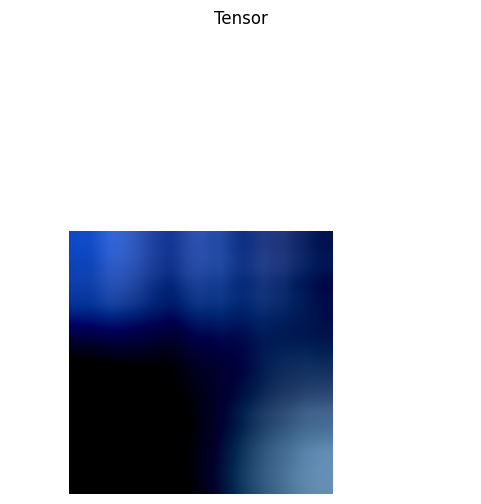

In [40]:
visualize_tensor(img_pairs[0][1])

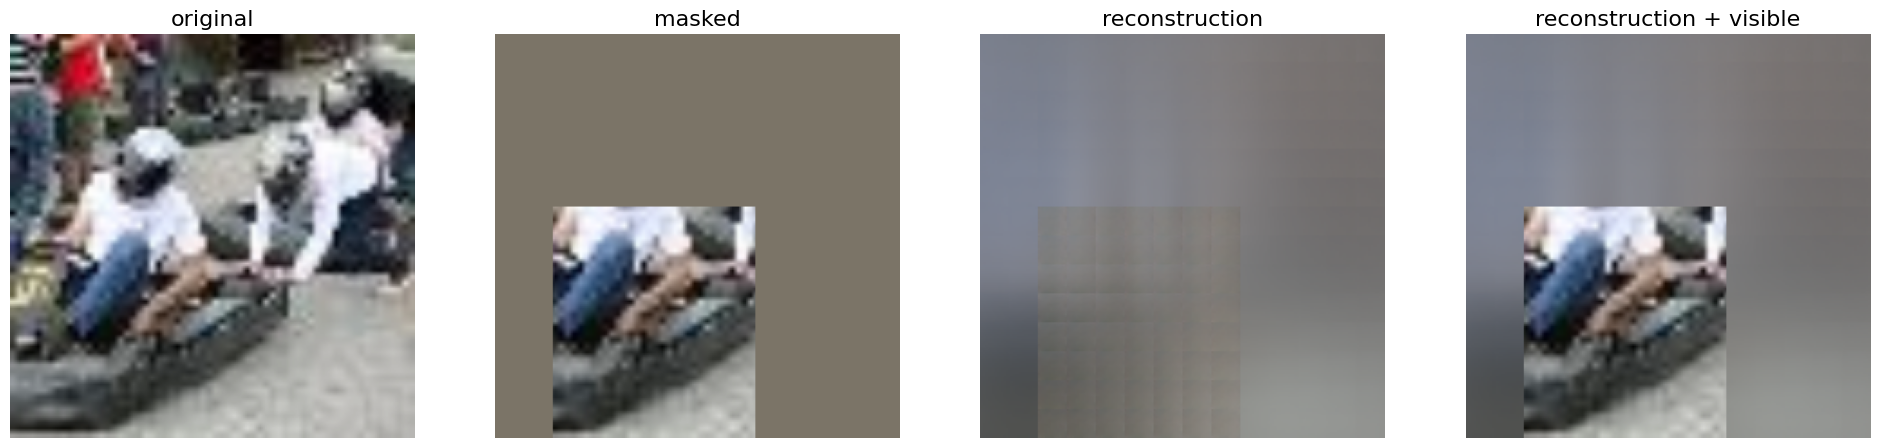

In [41]:
visualize_reconstruction(img_pairs[0][0], img_pairs[0][1], mae_model)